In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

/opt/conda/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
#모델 로드
model_name = 'klue/roberta-large'
load_model = '/opt/ml/level2_klue_nlp-level2-nlp-11/dataset/best_model/klue_roberta-large_2_1'


In [4]:
#학습했던 배치 사이즈
batch_size = 32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(load_model)
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32000, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
         

In [5]:
#import 라이브러리
import pandas as pd
import numpy as np
import pickle as pickle
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn.functional as F


In [6]:
#RE-Dataset 로드
class RE_Dataset(torch.utils.data.Dataset):
    """Dataset 구성을 위한 class."""

    def __init__(self, pair_dataset: pd.DataFrame, labels: np.ndarray):
        self.pair_dataset = pair_dataset
        self.labels = labels

    def __getitem__(self, idx: int) -> torch.Tensor:
        item = {
            key: val[idx].clone().detach() for key, val in self.pair_dataset.items()
        }
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self) -> int:
        return len(self.labels)

In [7]:
# 기타 함수들 로드
def label_to_num(label: np.ndarray) -> list:
    num_label = []
    with open("/opt/ml/code/dict_label_to_num.pkl", "rb") as f:
        dict_label_to_num = pickle.load(f)
    for v in label:
        num_label.append(dict_label_to_num[v])

    return num_label

def num_to_label(label: np.ndarray) -> list:
    """
    숫자로 되어 있던 class를 원본 문자열 라벨로 변환 합니다.
    """
    origin_label = []
    with open("/opt/ml/code/dict_num_to_label.pkl", "rb") as f:
        dict_num_to_label = pickle.load(f)
    for v in label:
        origin_label.append(dict_num_to_label[v])

    return origin_label

In [8]:
# 기타 함수들 로드
def preprocessing_dataset(dataset: pd.DataFrame) -> pd.DataFrame:
    """처음 불러온 csv 파일을 원하는 형태의 DataFrame으로 변경 시켜줍니다."""
    subject_entity = []
    object_entity = []
    for i, j in zip(dataset["subject_entity"], dataset["object_entity"]):
        i = i[1:-1].split(",")[0].split(":")[1]
        j = j[1:-1].split(",")[0].split(":")[1]

        subject_entity.append(i)
        object_entity.append(j)
    out_dataset = pd.DataFrame(
        {
            "id": dataset["id"],
            "sentence": dataset["sentence"],
            "subject_entity": subject_entity,
            "object_entity": object_entity,
            "label": dataset["label"],
        }
    )
    return out_dataset
    
def load_data(dataset_dir: str) -> pd.DataFrame:
    """csv 파일을 경로에 맞게 불러 옵니다."""
    pd_dataset = pd.read_csv(dataset_dir)
    dataset = preprocessing_dataset(pd_dataset)

    return dataset


def tokenized_dataset(dataset: pd.DataFrame, tokenizer: AutoTokenizer) -> torch.Tensor:
    """tokenizer에 따라 sentence를 tokenizing 합니다."""
    concat_entity = []
    for e01, e02 in zip(dataset["subject_entity"], dataset["object_entity"]):
        temp = ""
        temp = e01 + "[SEP]" + e02
        concat_entity.append(temp)
    tokenized_sentences = tokenizer(
        concat_entity,
        list(dataset["sentence"]),
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=256,
        add_special_tokens=True,
    )
    return tokenized_sentences

def get_dataset(data_path: str, tokenizer: AutoTokenizer) -> RE_Dataset:
    """데이터셋을 Trainer에 넣을 수 있도록 처리하여 리턴합니다.

    Args:
        data_path (str): 가져올 데이터의 주소입니다.
        tokenizer (AutoTokenizer): 데이터를 토큰화할 토크나이저입니다.

    Returns:
        pd.DataFrame: _description_
    """
    dataset = load_data(data_path)
    dataset_label = label_to_num(dataset["label"].values)
    # tokenizing dataset
    dataset_tokens = tokenized_dataset(dataset, tokenizer)
    # make dataset for pytorch.
    dataset = RE_Dataset(dataset_tokens, dataset_label)
    return dataset

In [9]:
#토큰화된 데이터셋 준비
valid_dataset = get_dataset('/opt/ml/level2_klue_nlp-level2-nlp-11/dataset/train/new_valid.csv',tokenizer)

In [10]:
#inference 함수 로드
def inference(model, tokenized_sent, batch_size, device):
    """
    test dataset을 DataLoader로 만들어 준 후,
    batch_size로 나눠 model이 예측 합니다.
    """
    dataloader = DataLoader(tokenized_sent, batch_size, shuffle=False)
    model.eval()

    output_pred = []
    output_prob = []
    for i, data in enumerate(tqdm(dataloader)):
        with torch.no_grad():
            outputs = model(
                input_ids=data["input_ids"].to(device),
                attention_mask=data["attention_mask"].to(device),
                token_type_ids=data["token_type_ids"].to(device),
            )
        logits = outputs[0]
        prob = F.softmax(logits, dim=-1).detach().cpu().numpy()
        logits = logits.detach().cpu().numpy()
        result = np.argmax(logits, axis=-1)

        output_pred.append(result)
        output_prob.append(prob)

    return (
        np.concatenate(output_pred).tolist(),
        np.concatenate(output_prob, axis=0).tolist(),
    )

In [11]:
#infernce 저장
pred_answer, output_prob = inference(
    model, valid_dataset, batch_size , device)  # model에서 class 추론
pred_answer = num_to_label(pred_answer)  # 숫자로 된 class를 원래 문자열 라벨로 변환.

100%|██████████| 203/203 [01:24<00:00,  2.40it/s]


In [12]:
print(pred_answer[:5])

['org:top_members/employees', 'org:top_members/employees', 'no_relation', 'org:top_members/employees', 'org:top_members/employees']


In [13]:
#valid 데이터 로드
valid_df = pd.read_csv('/opt/ml/level2_klue_nlp-level2-nlp-11/dataset/train/new_valid.csv')
valid_df = preprocessing_dataset(valid_df)

In [14]:
valid_df['pred_answer'] = pred_answer

In [15]:
valid_df.head()

,id,sentence,subject_entity,object_entity,label,pred_answer
0,29197,"이날 행사는 권오봉 여수시장, 김형국 GS칼텍스 사장 등이 참석했다.",'GS칼텍스','김형국',org:top_members/employees,org:top_members/employees
1,2998,광주광역시(시장 이용섭)가 올해 135억원을 투입해 선순환 사회적경제 일자리 800...,'광주광역시','이용섭',org:top_members/employees,org:top_members/employees
2,8036,"조선공산당, 조선인민당, 남조선신민당, 조선민족혁명당 등과 전평, 전농, 청년총동맹...",'조선민족혁명당','김원봉',no_relation,no_relation
3,29434,"이날 캠페인에는 하이트진로 김인규 대표, 변수남 부산소방본부장을 비롯해 부산진소방서...",'하이트진로','김인규',org:top_members/employees,org:top_members/employees
4,5082,홍정규 미래통합당은 23일 서울 종로에 황교안 대표를 단수후보로 추천했다.,'미래통합당','황교안',org:top_members/employees,org:top_members/employees


In [16]:
#valid_label, valid_predict 리스트 추출
valid_label = valid_df['label'].tolist()
valid_predict = valid_df['pred_answer'].tolist()

In [17]:
#valid_dict 정답 과 오답 count [True, False]

valid_dict = { i : [0,0] for i in list(set(valid_df['label'])) }
for x in zip(valid_label , valid_predict) :
    if x[0] == x[1] :
        valid_dict[x[0]][0] = valid_dict[x[0]][0] + 1
    else :
        valid_dict[x[0]][1] = valid_dict[x[0]][1] + 1



In [18]:
#데이터 총 개수별 sorted
valid_item = sorted(valid_dict.items(), key = lambda x : sum(x[1]), reverse= True)

In [19]:
#총 데이터 개수로 정렬, 오탐률 계산 및 저장
valid_percent = {}
for x , y in valid_item :
    print(f'{x:30} : {y}, {y[1] / sum(y) : 0.5f}')
    valid_percent[x] = y[1] / sum(y)

no_relation                    : [1434, 472],  0.24764
org:top_members/employees      : [831, 25],  0.02921
per:employee_of                : [625, 89],  0.12465
per:title                      : [395, 25],  0.05952
org:member_of                  : [300, 73],  0.19571
org:alternate_names            : [240, 24],  0.09091
per:origin                     : [199, 47],  0.19106
org:place_of_headquarters      : [195, 44],  0.18410
per:date_of_birth              : [224, 2],  0.00885
per:alternate_names            : [187, 13],  0.06500
per:spouse                     : [155, 4],  0.02516
per:colleagues                 : [79, 27],  0.25472
per:parents                    : [95, 9],  0.08654
org:founded                    : [82, 8],  0.08889
org:members                    : [53, 31],  0.36905
per:date_of_death              : [83, 0],  0.00000
org:product                    : [64, 12],  0.15789
per:children                   : [55, 5],  0.08333
per:other_family               : [21, 17],  0.44737
per:p

per:place_of_residence              :  0.92105 , label_data_count :   38, [True,False] : [3, 35]
per:other_family                    :  0.44737 , label_data_count :   38, [True,False] : [21, 17]
per:place_of_death                  :  0.37500 , label_data_count :    8, [True,False] : [5, 3]
org:members                         :  0.36905 , label_data_count :   84, [True,False] : [53, 31]
org:number_of_employees/members     :  0.33333 , label_data_count :    9, [True,False] : [6, 3]
per:place_of_birth                  :  0.30303 , label_data_count :   33, [True,False] : [23, 10]
per:siblings                        :  0.29630 , label_data_count :   27, [True,False] : [19, 8]
per:colleagues                      :  0.25472 , label_data_count :  106, [True,False] : [79, 27]
no_relation                         :  0.24764 , label_data_count : 1906, [True,False] : [1434, 472]
org:dissolved                       :  0.23077 , label_data_count :   13, [True,False] : [10, 3]
org:member_of           

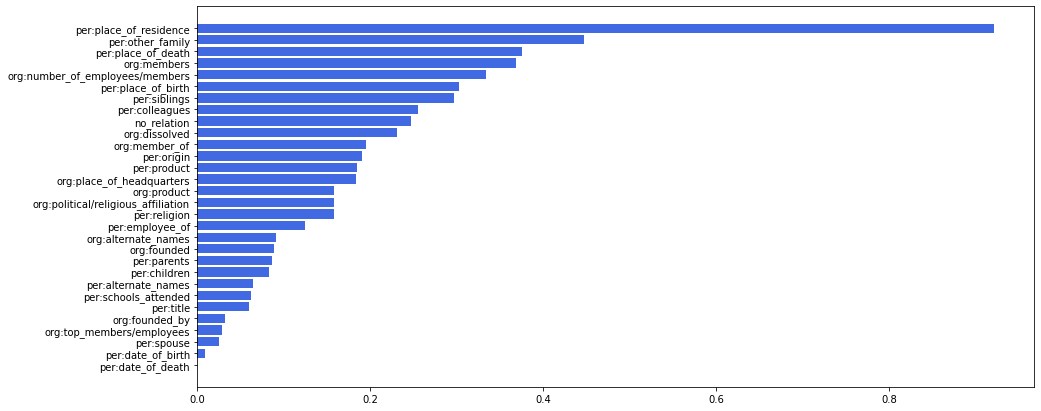

In [20]:
import matplotlib.pyplot as plt

# 오탐률 기준 정렬
temp_x = [] #라벨
temp_y = [] #퍼센트

for x, y in sorted(valid_percent.items() ,key = lambda x : x[1], reverse= True ): 
    print(f'{x:35} : {y : 0.5f} , label_data_count :{sum(valid_dict[x]) : 5}, [True,False] : {valid_dict[x]}')
    temp_x.append(x)
    temp_y.append(y)

#간단한 비율 확인 EDA
fig, axes = plt.subplots(1, 1, figsize=(15, 7))
axes.barh(temp_x[::-1], temp_y[::-1],color='royalblue')

plt.show()


In [24]:
#데이터 개수별 predict 결과 count 
pd.set_option('display.max_rows', None)
group = valid_df.groupby('label')['pred_answer'].value_counts()
group

label                                pred_answer                        
no_relation                          no_relation                            1434
                                     org:member_of                            77
                                     per:employee_of                          54
                                     per:title                                45
                                     org:place_of_headquarters                43
                                     org:top_members/employees                40
                                     per:colleagues                           31
                                     org:members                              29
                                     per:origin                               25
                                     org:product                              19
                                     org:founded                              16
                                    

['per:place_of_residence', 'per:other_family', 'per:place_of_death', 'org:members', 'org:number_of_employees/members', 'per:place_of_birth', 'per:siblings', 'per:colleagues', 'no_relation', 'org:dissolved']


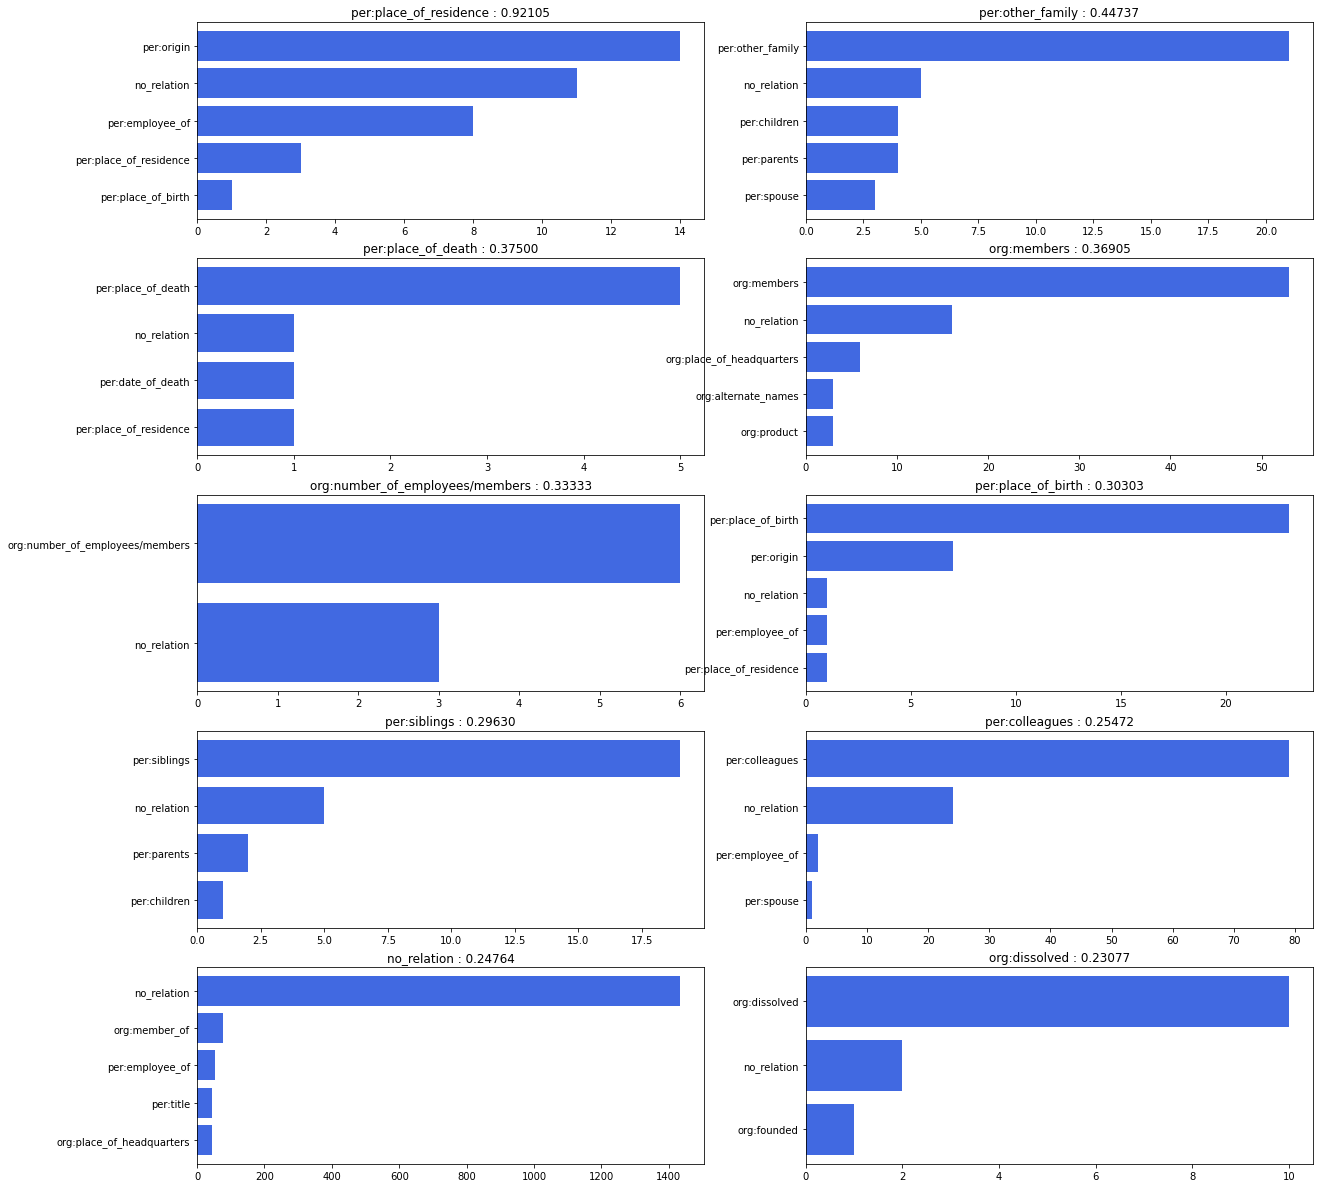

In [25]:
#정렬은 오탐률 기준입니다!

#top k 라벨별 EDA 
k = 10
top_k = temp_x[:k]
print(top_k)

#각 라벨별 predict 결과 top n 추출
n = 5

#x,y  조정
x = k//2 + k%2
y = 2

# 알맞게 fix size 조절
fig, axes = plt.subplots(x, y, figsize=(20, 21))

for i in range(k) :
    #print(i//y, i%y )
    axes[i//y][i%y].set_title(f'{top_k[i]} : {temp_y[i]:0.5f}')
    axes[i//y][i%y].barh(group[top_k[i]].index[:n][::-1], group[top_k[i]][:n][::-1], color='royalblue')
plt.show()